In [1]:
# !pip install libtiff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# from libtiff import TIFF
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import shutil
import pandas as pd
import random
import math
import cv2
from sklearn.model_selection import StratifiedKFold, KFold
from PIL import Image
import copy,time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CNNDIM = 2048
TIMESTAMPDIM = 128
STATEDIM = 128

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Cell Tracking/" |grep -i "\.json$"

train6.json
train.json
train_new_1.json
train_new_2.json
train_new_3.json
val6.json
val.json
val_new_1.json
val_new_2.json
val_new_3.json


In [2]:
dataset='original_3'

In [3]:
path = "/content/drive/My Drive/Cell Tracking/CellTracking1"
import json

dataset_paths={
    'original_3':{
        'train':"/content/drive/My Drive/Cell Tracking/train.json",
        'val':"/content/drive/My Drive/Cell Tracking/val.json"
    },
    'lsd1':{
        'train':"/content/drive/My Drive/Cell Tracking/train_new_1.json",
        'val':"/content/drive/My Drive/Cell Tracking/val_new_1.json"
    },
    'lsm710':{
       'train':"/content/drive/My Drive/Cell Tracking/train_new_2.json",
       'val':"/content/drive/My Drive/Cell Tracking/val_new_2.json"
    },
    'nikonxlight':{
       'train':"/content/drive/My Drive/Cell Tracking/train_new_3.json",
       'val':"/content/drive/My Drive/Cell Tracking/val_new_3.json"
    },
    'recql4':{
       'train':"/content/drive/My Drive/Cell Tracking/train_new_4.json",
       'val':"/content/drive/My Drive/Cell Tracking/val_new_4.json"
    }
}

train_files = []
val_files = []

# for filename in os.listdir(path):
#   mask_names = []
#   raw_names = []

#   for p in sorted(os.listdir(path+"/"+filename+"/Mask")):
#     mask_names.append(path+"/"+filename+"/Mask/"+p)
#   for p in sorted(os.listdir(path+"/"+filename+"/Raw")):
#     raw_names.append(path+"/"+filename+"/Raw/"+p)

#   df = pd.read_csv(path+"/"+filename+"/"+filename+"_Synchronization.csv")
#   vals=tuple(map(lambda x:int(x),df.columns[0].split(';')))
#   mask_names = tuple(mask_names)
#   raw_names = tuple(raw_names)

#   random_variable = random.random()
#   if random_variable<0.05:
#     val_files.append((raw_names,mask_names,vals))
#   else:
#     train_files.append((raw_names,mask_names,vals))

with open(dataset_paths[dataset]['train']) as f:
  train_files = json.load(f)

with open(dataset_paths[dataset]['val']) as f:
  val_files = json.load(f)

print(f"no. of train files: {len(train_files)}")
print(f"no. of val files: {len(val_files)}")

no. of train files: 260
no. of val files: 10


In [4]:
def clean_files(files:list):
  cnt=0
  temp_files=[]
  for i,data in enumerate(files):
    if len(data[0])==len(data[2]) and len(data[2])!=0:
      temp_files.append(data)
  return temp_files

train_files=clean_files(train_files)
val_files=clean_files(val_files)

print(f"no. of train files: {len(train_files)}")
print(f"no. of val files: {len(val_files)}")

no. of train files: 260
no. of val files: 10


In [ ]:
# from collections import Counter

# for l in train_files:
#   one_index=-1
#   two_index=-1
#   three_index=-1
#   try:
#     one_index=l[2].index(1)
#   except:
#     pass
#   try:
#     two_index=l[2].index(2)
#   except:
#     pass
#   try:
#     three_index=l[2].index(3)
#   except:
#     pass

#   all_counts=Counter(l[2])
#   if (min(all_counts.values())>=20):
#     print(all_counts)
#   print(two_index-one_index,three_index-two_index,len(l[2])-three_index)

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, max_len, d_model):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        self.pe = torch.zeros(1,max_len, d_model)
        self.pe[0,:, 0::2] = torch.sin(position * div_term)
        self.pe[0,: ,1::2] = torch.cos(position * div_term)
        self.pe = nn.Parameter(self.pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe
        return x

class TransformerLayer(nn.Module):
    def __init__(self,max_len,d_model,num_heads):
      super().__init__()
      self.mha = nn.MultiheadAttention(d_model,num_heads,dropout=0.1,batch_first=True)

      self.norm1 = nn.LayerNorm(d_model)
      self.norm2 = nn.LayerNorm(d_model)
      self.linear1 = nn.Linear(in_features=d_model,out_features=d_model//2)
      self.linear2 = nn.Linear(in_features=d_model//2,out_features=d_model)

      self.relu = nn.ReLU()

    def forward(self,query):
      out1 = query+self.mha(query=query,key=query,value=query)[0]
      out1 = self.norm1(out1)

      out2 = self.linear1(out1)
      out2 = self.relu(out2)
      out2 = self.linear2(out2)
      out2 = self.relu(out2)
      out2 = self.norm2(out2+out1)

      return out2


class Transformer(nn.Module):
    def __init__(self,max_len,d_model,num_heads,num_layers):
      super().__init__()
      self.pos = PositionalEncoding(max_len+1,d_model)
      self.cls = nn.Parameter(torch.randn(1,1,d_model))
      self.layers = nn.ModuleList([TransformerLayer(max_len,d_model,num_heads) for _
                                  in range(num_layers)])

    def forward(self,query):
      cls = self.cls.expand((query.size(0),1,self.cls.size(2)))
      query = torch.cat([cls,query],dim=1)
      query = self.pos(query)
      for layer in self.layers:
        query = layer(query)

      extracted_cls = query[:,0,:]
      return extracted_cls

# Checking Data

In [ ]:
for folder_index in range(len(train_files)):
  max_val_folder=None
  min_val_folder=None
  for file_name in train_files[folder_index][0]:
    arr=np.array(Image.open(file_name))
    file_name=file_name.split('/')[-1]
    if np.any(np.isnan(arr)):
      print(f"nan detected at {file_name} of folder_index:{folder_index}")
      input("Enter to continue!!!")
    # if max_val_folder is None:
    #   max_val_folder=np.max(arr)
    # max_val_folder=max(max_val_folder,np.max(arr))
    # if min_val_folder is None:
    #   min_val_folder=np.min(arr)
    # min_val_folder=min(min_val_folder,np.min(arr))
    print(f"{folder_index} {file_name} {np.max(arr)} {np.min(arr)}")


In [ ]:
im_arr=np.array(Image.open("/content/drive/My Drive/Cell Tracking/CellTracking1/"+"cell_0054/Raw/cell_0054_t=032_Raw.png"))
plt.imshow(im_arr)

In [ ]:
import torch.utils.model_zoo as model_zoo
from torch.nn import init

__all__ = ['xception']

model_urls = {
    'xception':'https://www.dropbox.com/s/1hplpzet9d7dv29/xception-c0a72b38.pth.tar?dl=1'
}


class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None

        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x



class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()


        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)



        #------- init weights --------
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #-----------------------------





    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x



def xception(pretrained=True,**kwargs):
    """
    Construct Xception.
    """

    model = Xception(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['xception']))

    model.fc = nn.Identity()
    for param in model.parameters():
      param.requires_grad = False
    return model


import torch.nn as nn


class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=True):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-3),x.size(-2),x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y


class CnnTransformer(nn.Module):
  def __init__(self,max_len,d_model,num_heads,num_layers):
    super().__init__()
    self.cnn = TimeDistributed(xception())
    self.transformer = Transformer(max_len,d_model,num_heads,num_layers)
    self.embed = nn.Embedding(90,TIMESTAMPDIM)
    self.embed2 = nn.Embedding(3,STATEDIM)

  def forward(self,x,timestamps,cellStates):
    timestamps = self.embed(timestamps)
    cellStates = self.embed2(cellStates)

    x = self.cnn(x)
    x = torch.concat([x,timestamps,cellStates],dim=-1)
    x = self.transformer(x)

    return x

In [5]:
from PIL import Image
# import tsfresh as ts

MAXFUTURE = 5
NUMFRAMES = 5
DMODEL = 2048
NUM = 10

def getImageFromPath(path):
  im=Image.open(path)
  t = transforms.ToTensor()(im)
  t = transforms.Resize((256,256))(t)
  t = torch.concat([t,t,t],dim=0)/torch.max(t)
  # raise Exception("divide by max")
  return t

class GetDataset(Dataset):
  def __init__(self,index_list):
    self.index_list = index_list
    self.normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])

  def __len__(self):
    return 1000

  def __getitem__(self,idx):
    video = random.choice(self.index_list)
    num_frames = len(video[2])

    indices = sorted(random.sample(range(0,num_frames-MAXFUTURE),NUMFRAMES))

    imageArr = [self.normalize(getImageFromPath(video[0][i]).float()) for i in indices]
    timeStampArr = indices
    cellStateArr = [video[2][i]-1 for i in indices]


    imageArr = torch.stack(imageArr,dim=0)
    timeStampArr = torch.as_tensor(timeStampArr)
    cellStateArr = torch.as_tensor(cellStateArr)

    timeFuture = random.choice(range(0,MAXFUTURE))
    predLabel = torch.as_tensor(video[2][indices[-1]+timeFuture]-1)

    timeFuture = torch.as_tensor(timeFuture)

    imageArr = imageArr.to(device).float()
    timeStampArr = timeStampArr.type(torch.LongTensor).to(device)
    cellStateArr = cellStateArr.type(torch.LongTensor).to(device)
    timeFuture = timeFuture.type(torch.LongTensor).to(device)
    predLabel = predLabel.to(device)


    return imageArr,timeStampArr,cellStateArr,timeFuture,predLabel

def getStatistics(tensor,model):
  out = model(tensor)
  len = out.size(0)
  # index = list(range(0,len))
  # id = [0 for i in range(0,len)]
  # column = list(range(0,DMODEL))

  # data = out.cpu().detach().numpy()
  # df0 = pd.DataFrame(data = data,index=index,columns=column)

  # df0['id'] = id
  # df0['ind'] = index

  # features=ts.extract_features(out[0],column_id="ind", column_sort="id", column_kind=None, column_value=None)
  mean = torch.mean(out,dim=0)
  std = torch.std(out,dim=0)

  return torch.concat([mean,std],axis=0)

class GetStatDataset(Dataset):
  def __init__(self,index_list,model):
    super().__init__()
    self.index_list = index_list
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    self.model = model

  def __len__(self):
    return 10000

  def __getitem__(self,ind):
    ind = random.choice(self.index_list)
    bin = random.choice([1,2,3])

    lists = dict()
    lists[1] = [i for i in range(len(ind[2])) if ind[2][i]==1]
    lists[2] = [i for i in range(len(ind[2])) if ind[2][i]==2]
    lists[3] = [i for i in range(len(ind[2])) if ind[2][i]==3]

    imageInd = random.sample(lists[bin],max(min(random.randint(0,len(lists[bin])-1),5),2))

    imageArr = [self.normalize(getImageFromPath(ind[0][i]).float()) for i in imageInd]
    imageArr = torch.stack(imageArr,dim=0)

    pred = torch.as_tensor(bin-1)
    imageArr = imageArr.to(device)
    ret = getStatistics(imageArr,self.model)

    return ret,pred.to(device)

class getGNNDataset(Dataset):
  def __init__(self,index_list,model):
    super().__init__()
    self.index_list = index_list
    self.model = model
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    self.len_=100

  def __len__(self):
    return self.len_

  def set_len(self,len_):
    self.len_=len_

  def __getitem__(self,idx):
    ind = random.choice(self.index_list)
    # startInd = random.choice(list(range(0,len(ind[2])-NUM-1)))
    # startInd=random.randint(0,len(ind[2])-NUM-1)
    # imageInd = list(range(startInd,startInd+NUM))

    num0 = len([i for i in range(len(ind[2])-NUM) if ind[2][i+NUM]==1 ])
    num1 = len([i for i in range(len(ind[2])-NUM) if ind[2][i+NUM]==2 ])
    num2 = len([i for i in range(len(ind[2])-NUM) if ind[2][i+NUM]==3 ])

    weights = []

    # for i in range(num0):
    #   weights.append(1/(3*num0))

    # for i in range(num1):
    #   weights.append(1/(3*num1))

    # for i in range(num2):
    #   weights.append(1/(3*num2))

    for i in range(len(ind[2])-NUM):
      if ind[2][i+NUM]==1:
        weights.append(1/(3*num0))
      elif ind[2][i+NUM]==2:
        weights.append(1/(3*num1))
      else:
        weights.append(1/(3*num2))

    startInd = random.choices(list(range(0,len(ind[2])-NUM)),weights=weights,k=1)[0]
    imageInd=range(startInd,startInd+NUM)

    imageArr = [self.normalize(getImageFromPath(ind[0][i]).float()) for i in imageInd]
    imageArr=torch.stack(imageArr,dim=0)

    timeStampArr = imageInd
    timeStampArr = torch.as_tensor(timeStampArr)
    timeStampArr = timeStampArr.type(torch.LongTensor).to(device)

    cellStateArr = [ind[2][i]-1 for i in imageInd]
    cellStateArr = torch.as_tensor(cellStateArr)
    cellStateArr = cellStateArr.type(torch.LongTensor).to(device)


    predNext = torch.as_tensor(ind[2][startInd+NUM]-1)

    imageArr = imageArr.to(device)
    predNext = predNext.float().to(device)
    return imageArr,timeStampArr,cellStateArr,predNext

def get_video_dict(indexes,model):
  return_dict = dict()
  return_dict[0] = list()
  return_dict[1] = list()
  return_dict[2] = list()

  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

  ind = random.choice(indexes)
  indices = list(range(0,len(ind[2])))

  for i in indices:
    img = getImageFromPath(ind[0][i]).float().to(device)
    img = normalize(img.unsqueeze(0))

    ret = model(img).squeeze(0)
    return_dict[ind[2][i]-1].append(ret.cpu().detach().numpy())

  temp_0 = np.array(return_dict[0])
  temp_1 = np.array(return_dict[1])
  temp_2 = np.array(return_dict[2])

  index_0 = list(range(0,len(return_dict[0])))
  index_1 = list(range(0,len(return_dict[1])))
  index_2 = list(range(0,len(return_dict[2])))

  column = list(range(0,DMODEL))

  df0 = pd.DataFrame(data = temp_0,index=index_0,columns=column)
  df1 = pd.DataFrame(data = temp_1,index=index_1,columns=column)
  df2 = pd.DataFrame(data = temp_2,index=index_2,columns=column)

  df0['id'] = index_0
  df1['id'] = index_1
  df2['id'] = index_2

  df0['ind'] = [0 for i in index_0]
  df1['ind'] = [1 for i in index_1]
  df2['ind'] = [2 for i in index_2]

  return_dict[0] = df0
  return_dict[1] = df1
  return_dict[2] = df2

  return return_dict


In [ ]:
vgg16=models.vgg16(pretrained=True)
vgg16.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
vgg16.classifier=nn.Identity()
# vgg16.classifier[6]=nn.Identity()

# for param in vgg16.parameters():
#   param.requires_grad = False
vgg16.to(device)
vgg16

In [ ]:

# import tsfresh as ts
vgg16 = None
if vgg16 is not None:
  del(vgg16)
vgg16 = models.resnet50(pretrained=True)
vgg16.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
vgg16.fc = nn.Flatten()
vgg16=vgg16.to(device)
vgg16
# out = get_video_dict(train_files,vgg16)
# features = dict()
# del(out)

In [ ]:
densenet=models.densenet121(pretrained=True)
densenet.classifier=nn.Identity()
# for param in densenet.parameters():
#   param.requires_grad=False
densenet.to(device)
densenet

In [ ]:
class ScaledInception(nn.Module):
  def __init__(self,_size=(512,512)):
    super().__init__()

    self.scaler=transforms.Resize(_size)
    self.inception=models.inception_v3(pretrained=True)
    self.inception.fc=nn.Identity()

  def forward(self,x):
    return self.inception(self.scaler(x))[0] # get only the linear layer output and ignore the aux_logits


scaled_inception=ScaledInception((512,512))
scaled_inception.to(device)
scaled_inception

In [ ]:
vit=models.maxvit_t(pretrained=True)
vit.classifier=nn.Identity()
vit.to(device)
vit

In [ ]:
class PredNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnnTransformer = CnnTransformer(5,CNNDIM+TIMESTAMPDIM+STATEDIM,2,4)
    self.embedding = nn.Embedding(90,TIMESTAMPDIM)

    self.fc1 = nn.Sequential(
        nn.Linear(CNNDIM+TIMESTAMPDIM+STATEDIM,1024),
        nn.ReLU(),
        nn.Linear(1024,512)
    )

    self.fc2 = nn.Sequential(
        nn.Linear(512+TIMESTAMPDIM,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,3)
    )

  def forward(self,imageArr,timeStampArr,cellStateArr,timeFuture):
    feat = self.cnnTransformer(imageArr,timeStampArr,cellStateArr)
    feat = self.fc1(feat)

    embedding = self.embedding(timeFuture)

    feat = torch.cat([feat,embedding],dim=1)
    feat = self.fc2(feat)
    return feat

class Mlp(nn.Module):
  def __init__(self):
    super().__init__()

    self.seq = nn.Sequential(
        nn.Linear(2*DMODEL,DMODEL),
        nn.ReLU(),
        nn.Linear(DMODEL,DMODEL//2),
        nn.ReLU(),
        nn.Linear(DMODEL//2,DMODEL//4),
        nn.ReLU(),
        nn.Linear(DMODEL//4,DMODEL//8),
        nn.ReLU(),
        nn.Linear(DMODEL//8,3)
    )

  def forward(self,x):
    return self.seq(x)

In [ ]:
model = Mlp()
model.to(device)
dataset = GetStatDataset(train_files,vgg16)
loader = DataLoader(dataset,batch_size=4)
adam = torch.optim.Adam(model.parameters(),lr=0.0001)

In [6]:
DIM=512
"""
  VGG16: 512
  RESNET50:2048
  RESNET18:512
  DENSENET201:1920
  DENSENET161:2208
  DENSENET121:1024
  INCEPTION:2048
"""
CLASS=3

# ContrastiveLossResnet

In [8]:


class CenterLoss(nn.Module):
    def __init__(self, num_classes=CLASS, feat_dim=DIM, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu: classes = classes.cuda()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return x,loss

class finalModel(nn.Module):
  def __init__(self,baseline,classifier):
    super().__init__()
    self.baseline = baseline
    self.classifier = classifier
    self.centre = CenterLoss()

  def forward(self,x,trueLabels):
    feats = self.baseline(x)
    feats,loss = self.centre(feats,trueLabels)
    preds = self.classifier(feats)
    return preds,loss

contrastive_resnet_model= torch.load("/content/drive/My Drive/Cell Tracking/classifier3_centerresnet18_2_final.pth").baseline.to(device)
contrastive_resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
!ls "/content/drive/My Drive/Cell Tracking/" | grep -i "^classifier3_"

classifier3_centerresnet18_2_final_lsd1.pth
classifier3_centerresnet18_2_final_lsd2.pth
classifier3_centerresnet18_2_final_lsd3.pth
classifier3_centerresnet18_2_final_lsd4.pth
classifier3_centerresnet18_2_final.pth
classifier3_centerresnet50_2_final_lsd2.pth
classifier3_centerresnet50_2_final_lsd3.pth
classifier3_centervgg16_2_final_lsd1.pth
classifier3_centerVgg16_2_final_lsd2.pth
classifier3_centerVgg16_2_final_lsd3.pth
classifier3_centerVgg16_2_final_lsd4.pth
classifier3_centreresnet_2_final.pth
classifier3_centreresnet_2.pth
classifier3_centreresnet50_2_final_lsd1.pth
classifier3_centreresnet50_2_final.pth
classifier3_centreresnet.pth
classifier3_centrevgg16_2_final.pth
classifier3_contrastivecentrevgg16_2_final.pth


In [ ]:
class Trainer:
  stepsPerEpoch = 50

  def __init__(self,model,dataLoader,optimizer):
    self.history = dict()
    self.model = model
    self.optimizer = optimizer
    self.loader = dataLoader

  def train_one_epoch(self):
    loader = iter(self.loader)
    running_loss=0
    running_acc = 0

    for i in range(Trainer.stepsPerEpoch):
      # imgs,timeStamps,cellStates,timeFuture,trueLabel = loader.next()
      imgs,trueLabel = loader.next()

      self.optimizer.zero_grad()
      # pred = self.model(imgs,timeStamps,cellStates,timeFuture)
      pred = self.model(imgs)
      loss = nn.CrossEntropyLoss()(pred,trueLabel)
      loss.backward()
      self.optimizer.step()

      t = trueLabel.cpu().detach().numpy()
      p = pred.cpu().detach().numpy()
      p = np.argmax(p,axis=1)
      # print(t)
      # print(p)

      running_acc+=(np.sum((p==t).astype(float)))/4
      running_loss+=loss.item()

    return running_loss/Trainer.stepsPerEpoch,running_acc/Trainer.stepsPerEpoch

  def train(self,epochs):
    for i in range(epochs):
      l,a = self.train_one_epoch()

      self.history[i] = dict()
      self.history[i]['loss'] = l

      print(f"After epoch {i} loss is {l} and acc is {a}")

train = Trainer(model,loader,adam)

NameError: ignored

In [ ]:
gnn_data=getGNNDataset(index_list=train_files,model=None)
gnn_data_loader=DataLoader(gnn_data,batch_size=4,shuffle=True)

In [9]:
#the main differene of this implementation is that the gso is changing throughout the training

# 2.1

def FilterFunction(h, S, x):
    #x->(b,n,f)
    K = h.shape[0]
    B = x.shape[0]
    N = x.shape[1]
    f=  x.shape[2]

    # x = x.reshape([B, 1, N])
    #(b,f,n)
    x=x.permute(0,2,1)
    S = S.reshape([B, N, N]) #### change since resnet
    z = h[0]*x
    running_x=x
    for k in range(1, K):
      runnning_x=torch.matmul(x,S)
      z+=h[k]*running_x
    return z.permute(0,2,1)

# 2.2

class GraphFilter(nn.Module):
    def __init__(self, gso, k):
        super().__init__()
        self.gso = torch.tensor(gso)
        self.n = gso.shape[0]
        self.k = k
        self.weight = nn.Parameter(torch.randn(self.k))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / (math.sqrt(self.k)+1e-5)
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, mix_x_gso):
        x,gso=mix_x_gso
        return FilterFunction(self.weight, gso, x)

# 3.1

class GraphPerceptron(nn.Module):
    def __init__(self, gso, k, sigma):
        super().__init__()
        self.gso = torch.tensor(gso)
        self.n = gso.shape[0]
        self.k = k
        self.sigma = sigma
        self.weight = nn.Parameter(torch.randn(self.k))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / (math.sqrt(self.k)+1e-5)
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, mix_x_gso):
        # print(mix_x_gso)
        x,gso=mix_x_gso
        y = FilterFunction(self.weight, gso, x)
        y = self.sigma(y)
        return (y,gso)

# 3.2

class MLGNN(nn.Module):
    def __init__(self, gso, l, k, sigma):
        super().__init__()
        layers = []
        for layer in range(l):
            layers.append(GraphPerceptron(gso, k, sigma))
        self.layers = nn.Sequential(*layers)

    def forward(self, mix_x_gso):
        x,gso=mix_x_gso
        y = self.layers((x,gso))
        return y

class f_to_1_combiner(nn.Module):
  def __init__(self,gso,k,sigma,f,f_=1):
    super().__init__()
    self.gso=gso
    self.k=k
    self.sigma=sigma
    self.f=f
    self.f_=f_
    self.weights=nn.Parameter(torch.randn((k,self.f,self.f_)))#k,f,g


  def forward(self,mix_x_gso):
    x,gso=mix_x_gso
    # x -> (b,n,f)
    b,n,f=x.shape
    gso=gso.reshape([-1,n,n])

    running_x=x
    y=torch.zeros((b,n,self.f_),dtype=torch.float32).to(device)
    for k in range(self.k):
      y+=torch.matmul(running_x,self.weights[k])
      running_x=torch.matmul(gso,running_x) #unsure about the dimension here

    y=self.sigma(y)
    y=y.reshape([b,n,self.f_])
    return y

class simple_nn(nn.Module):
  def __init__(self,in_size,hid_size,out_size):
    super().__init__()
    layers=[
        nn.Linear(in_size,hid_size),
        # nn.ReLU(),
        nn.Tanh(),
        nn.Linear(hid_size,hid_size),
        # nn.ReLU(),
        nn.Tanh(),
        nn.Linear(hid_size,hid_size),
        # nn.ReLU(),
        nn.Tanh(),
        nn.Linear(hid_size,out_size),
        # nn.ReLU()
    ]
    self.layers=nn.Sequential(*layers)

  def forward(self,x):
    #b,n format
    return self.layers(x)

class CombinedLayers(nn.Module):
    def __init__(self,gso,l,k,sigma,f,f_,in_size,hid_size,out_size):
      super().__init__()
      self.graph_layer=MLGNN(gso,l,k,sigma)
      self.combiner_layer=f_to_1_combiner(gso,k,sigma,f,f_)
      self.fc=simple_nn(f_*in_size,hid_size,out_size)

    def forward(self,mix_x_gso):
      x,gso=mix_x_gso
      x=self.graph_layer((x,gso))
      x=self.combiner_layer(x)
      x=torch.flatten(x,start_dim=1)
      x=self.fc(x)

      return x


In [10]:
# one_data = getGNNDataset(train_files,model=None)[0]

def get_augmented_data(feature_model,imageArr,timeStampArr,cellStateArr,predNext):
  listy=[feature_model(i.unsqueeze(0)).view(1,DIM) for i in imageArr]#[1,3,256,256]
  listy=torch.cat(listy,dim=0)
  x=torch.cat([listy,timeStampArr.view(-1,1),cellStateArr.view(-1,1)],dim=1)#.view(dtype=torch.float32)
  # x=x.cpu()
  # print(x.shape)
  return x.detach(),predNext

def get_normalized_gso(gso):
  n,_=gso.shape
  d_sqrt_inv=torch.zeros(n,n).to(device)
  for i in range(n):
    d_sqrt_inv[i][i]=1/(torch.sum(gso[i])+1e-5)
  d_sqrt_inv=torch.sqrt(d_sqrt_inv)
  # d_sqrt_inv = d_sqrt_inv.to(device)
  # print(gso)
  # return ((torch.eye(n).to(device)-d_sqrt_inv) @ gso @ d_sqrt_inv).float()
  return ((torch.eye(n).to(device)-d_sqrt_inv @ gso @ d_sqrt_inv)).float() ####change here since resnet

def get_gso(x):
  n,_=x.shape
  gso=torch.zeros((n,n),dtype=torch.float32)
  sim=nn.CosineSimilarity(dim=0)
  for i in range(n):
    for j in range(i+1,n):
      # gso[i][j]=sim(x[i],x[j]) #####change since resnet
      gso[i][j]=sim(x[i],x[j])*0.5+0.5
      gso[j][i]=gso[i][j]

  ##### change since new resnet
  gso=(gso-torch.mean(gso))/(torch.std(gso)+1e-9)
  gso=gso-torch.min(gso)

  #change this normalizing scheme
  gso = gso.to(device)
  gso=get_normalized_gso(gso).to(device)
  # eigenvalues, _ = np.linalg.eig(gso)
  # gso=gso / (np.max(eigenvalues.real)+1e-5)

  # gso = gso/torch.norm(gso) ####change here since resnet
  return gso

# x,p=get_augmented_data(*one_data)
# print(x.shape)
# print(p.shape)

In [11]:
def smoothen_labels(y_real,epsilon,tot_classes):
  return (1-epsilon)*y_real+(epsilon/tot_classes)*torch.ones_like(y_real)

__random_y=torch.randn(5,3)
__random_y=(__random_y==torch.max(__random_y,axis=1)[0].reshape(5,1)).to(__random_y.dtype)
print(__random_y,smoothen_labels(__random_y,0.1,3))

tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.]]) tensor([[0.0333, 0.9333, 0.0333],
        [0.0333, 0.0333, 0.9333],
        [0.0333, 0.0333, 0.9333],
        [0.9333, 0.0333, 0.0333],
        [0.0333, 0.0333, 0.9333]])


In [12]:
epoch_num=100
num_frame=NUM
loss_func=nn.CrossEntropyLoss()
f=DIM+2
label_smoothening_eps=0.1

In [13]:
feature_model=contrastive_resnet_model
# model=CombinedLayers(gso=torch.zeros((num_frame,num_frame)),k=5,l=8,sigma=nn.Tanh(),f=f,in_size=num_frame,out_size=3) # contr.resnet50 best(frame=10,k=5,l=8,f=dim+2,hid_size=128,f_=1)
#some changes to f_1 combiner since last time

# model=CombinedLayers(gso=torch.zeros((num_frame,num_frame)),k=5,l=8,sigma=nn.Tanh(),f=f,f_=32,in_size=num_frame,hid_size=128,out_size=3) # contr.resnet50 new best(frame=10,k=5,l=8,f=dim+2)

model=CombinedLayers(gso=torch.zeros((num_frame,num_frame)),k=6,l=8,sigma=nn.Tanh(),f=f,f_=64,in_size=num_frame,hid_size=128,out_size=3)
model.to(device)

<ipython-input-9-89c4fbda0f52>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.gso = torch.tensor(gso)


CombinedLayers(
  (graph_layer): MLGNN(
    (layers): Sequential(
      (0): GraphPerceptron(
        (sigma): Tanh()
      )
      (1): GraphPerceptron(
        (sigma): Tanh()
      )
      (2): GraphPerceptron(
        (sigma): Tanh()
      )
      (3): GraphPerceptron(
        (sigma): Tanh()
      )
      (4): GraphPerceptron(
        (sigma): Tanh()
      )
      (5): GraphPerceptron(
        (sigma): Tanh()
      )
      (6): GraphPerceptron(
        (sigma): Tanh()
      )
      (7): GraphPerceptron(
        (sigma): Tanh()
      )
    )
  )
  (combiner_layer): f_to_1_combiner(
    (sigma): Tanh()
  )
  (fc): simple_nn(
    (layers): Sequential(
      (0): Linear(in_features=640, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): Tanh()
      (6): Linear(in_features=128, out_features=3, bias=True)
    )
  )
)

In [14]:
model((torch.randn(2,num_frame,f).to(device),torch.randn(2,num_frame,num_frame).to(device)))

tensor([[-0.0742, -0.0136, -0.0341],
        [-0.0774, -0.0193, -0.0456]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [15]:
def validate_model(model,feature_model,val_data_loader):
  model.eval()
  actual_y=[]
  predicted_y=[]
  with torch.no_grad():
    cnt=0
    tot=0
    tot_loss=0
    loss_func=nn.CrossEntropyLoss()
    for imageArrarr,timeStampArrarr,cellStateArrarr,predNextarr in val_data_loader:
      batch_size=imageArrarr.shape[0]
      aug_data=[get_augmented_data(feature_model,imageArrarr[i],timeStampArrarr[i],cellStateArrarr[i],predNextarr[i]) for i in range(batch_size)]
      batch_x=torch.cat([aug_data[i][0].reshape([1,num_frame,-1]) for i in range(batch_size)],dim=0)
      batch_y=torch.zeros((batch_size,3)).to(device)
      for i in range(batch_size):
        batch_y[i][int(aug_data[i][1])]=1
      gso=torch.cat([get_gso(aug_data[i][0]).reshape([1,num_frame,num_frame]) for i in range(batch_size)],dim=0) #### change since resnet

      batch_y = torch.argmax(batch_y,dim=1)

      output_y=model((batch_x,gso))
      loss_now=loss_func(output_y,batch_y)
      tot_loss+=loss_now.item()
      print(f"loss_now: {loss_now.item()}")
      cnt_c=0
      for i in range(batch_size):
        tot+=1
        if batch_y[i]==torch.argmax(smax(output_y[i])).item():
          cnt_c+=1
        actual_y.append(batch_y[i].item())
        predicted_y.append(torch.argmax(smax(output_y[i])).item())
      cnt+=cnt_c
      print(f"batch_acc: {cnt_c/batch_size}")
    print(f"tot_loss: {tot_loss/len(val_data_loader)}, accuracy: {cnt/tot}")

    return actual_y,predicted_y

In [16]:
# optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)# changed to 1e-3 from 1e-4
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[25,50,75,100],gamma=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.75)
batch_size=16
smax=nn.Softmax(dim=0)
loss_now=torch.inf
best_model=None


gnn_data=getGNNDataset(index_list=train_files,model=None)
gnn_data.set_len(400)
gnn_data_loader=DataLoader(gnn_data,batch_size=batch_size,shuffle=True)
val_gnn_dataset=getGNNDataset(index_list=val_files,model=None)
# val_gnn_dataset.set_len(400)
val_gnn_data_loader=DataLoader(val_gnn_dataset,batch_size=10,shuffle=True)

In [20]:
model.train()



trainLoss=[]
trainAcc = []


###
#k val= 5
###


# print("len is: ",len(gnn_data_loader))

__grad_vals_prev=None
__grad_vals_now=[]
k_fold_val=1

for epoch in range(epoch_num):
  model.train()
  same_parameter_anywhere=False
  nan_anywhere=False

  batch_number=0
  tot_loss=0
  tot_acc=0
  loop_start=time.time()
  for imageArrarr,timeStampArrarr,cellStateArrarr,predNextarr in gnn_data_loader:
    aug_data=[get_augmented_data(feature_model,imageArrarr[i],timeStampArrarr[i],cellStateArrarr[i],predNextarr[i]) for i in range(batch_size)]
    batch_x=torch.cat([aug_data[i][0].reshape([1,num_frame,-1]) for i in range(batch_size)],dim=0)
    print(f"training shape of data: {batch_x.shape} and lr: {optimizer.param_groups[0]['lr']}")
    batch_y=torch.zeros((batch_size,3)).to(device)
    batch_y.requires_grad=False

    for i in range(batch_size):
      batch_y[i][int(aug_data[i][1])]=1
    batch_y=smoothen_labels(batch_y,label_smoothening_eps,CLASS)
    # gso=torch.cat([get_gso(aug_data[i][0]).reshape([1,num_frame,num_frame]) for i in range(batch_size)],dim=0).mean(dim=0) ####change since resnet
    gso=torch.cat([get_gso(aug_data[i][0]).reshape([1,num_frame,num_frame]) for i in range(batch_size)],dim=0)
    batch_y = torch.argmax(batch_y,dim=1)


    optimizer.zero_grad()
    output_y=model((batch_x,gso))

    loss_val=loss_func(output_y,batch_y)
    loss_val.backward()
    for i in model.parameters():
      __grad_vals_now.extend(torch.flatten(i).tolist())

    if __grad_vals_prev is not None:
      # print(len(__grad_vals_prev),len(__grad_vals_now))
      # print("Same parameters: ",__grad_vals_prev==__grad_vals_now)
      if __grad_vals_now==__grad_vals_prev:
        same_parameter_anywhere=True
    if torch.isnan(torch.tensor(__grad_vals_now)).any():
      nan_anywhere=True

    __grad_vals_prev=__grad_vals_now
    __grad_vals_now=[]
    optimizer.step()



    # print(output_y.shape)

    with torch.no_grad():
      print(f"for batch {batch_number}: ",output_y.detach().cpu(),batch_y.detach().cpu(),loss_val.detach().cpu().item())
      tot_loss+=loss_val.cpu().item()
      cnt=0
      for i in range(batch_size):
        if batch_y[i]==torch.argmax(smax(output_y[i])).item():
          cnt+=1
      tot_acc+=cnt/batch_size
    batch_number+=1
    loop_start=time.time()

  tot_loss/=batch_number
  tot_acc/=batch_number

  trainAcc.append(tot_acc)
  trainLoss.append(tot_loss)
  print(f"epoch: {epoch}, loss: {tot_loss}, acc: {tot_acc}")
  print(f"nan: {nan_anywhere} same_parameter: {same_parameter_anywhere}")
  # print("printing parameters:",*model.parameters())
  scheduler.step()
  if (epoch+1)%5==0:
    if tot_loss<loss_now:
      loss_now=tot_loss
      print("saving model.")
      torch.save(model,"/content/drive/MyDrive/Cell Tracking/graph_original3_centreresnet18.pth")
  if (epoch+1)%5==0:
    print(f"validating model.... at epoch_{epoch}")
    validate_model(model,feature_model,val_gnn_data_loader)

training shape of data: torch.Size([16, 10, 514]) and lr: 0.00042187500000000005
for batch 0:  tensor([[ 3.2179, -0.0297, -3.7561],
        [ 2.3137,  0.1253, -2.8892],
        [-2.2644, -1.3256,  4.0473],
        [-4.0912, -0.4832,  5.1527],
        [ 3.4067, -0.8492, -2.9962],
        [ 1.9022,  0.7616, -3.1764],
        [-3.9760,  2.4396,  1.5168],
        [ 1.9962,  0.0389, -2.4255],
        [-2.6887,  4.6250, -2.0922],
        [-4.0763, -1.0010,  5.8666],
        [-3.5301,  2.0573,  1.4671],
        [ 2.4223,  0.4891, -3.4429],
        [-2.1466,  4.3917, -2.4655],
        [-3.7515, -1.7324,  6.5881],
        [-1.3592, -1.6517,  3.3509],
        [-3.0093, -1.9881,  5.8180]]) tensor([0, 0, 2, 2, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2, 2]) 0.20438411831855774
training shape of data: torch.Size([16, 10, 514]) and lr: 0.00042187500000000005
for batch 1:  tensor([[ 3.4052, -0.6187, -3.2588],
        [ 2.8732, -0.2726, -3.0490],
        [-2.4303,  4.4685, -2.2275],
        [ 2.4592, -0.2397, -2

KeyboardInterrupt: ignored

In [18]:
val_batch_size=20
num_frame=10
smax=nn.Softmax(dim=0)

test_model=torch.load("/content/drive/My Drive/Cell Tracking/graph_original3_centreresnet18.pth")

val_gnn_dataset=getGNNDataset(index_list=val_files,model=None)
val_gnn_dataset.set_len(2000)
val_gnn_data_loader=DataLoader(val_gnn_dataset,batch_size=val_batch_size,shuffle=True)



In [19]:
act_y,pred_y=validate_model(test_model,contrastive_resnet_model,val_gnn_data_loader)

loss_now: 0.3518330156803131
batch_acc: 0.85
loss_now: 0.5448037385940552
batch_acc: 0.85
loss_now: 0.0693308487534523
batch_acc: 1.0
loss_now: 0.19880017638206482
batch_acc: 0.95
loss_now: 0.30530065298080444
batch_acc: 0.95
loss_now: 0.04086509346961975
batch_acc: 1.0
loss_now: 0.25949007272720337
batch_acc: 0.9
loss_now: 0.10513180494308472
batch_acc: 0.95
loss_now: 0.16539520025253296
batch_acc: 0.95
loss_now: 0.21646468341350555
batch_acc: 0.95
loss_now: 0.24276086688041687
batch_acc: 0.95
loss_now: 0.05645940452814102
batch_acc: 1.0
loss_now: 0.11097218096256256
batch_acc: 1.0
loss_now: 0.09043120592832565
batch_acc: 1.0
loss_now: 0.05169146507978439
batch_acc: 0.95
loss_now: 0.122007355093956
batch_acc: 0.95
loss_now: 0.14295318722724915
batch_acc: 0.95
loss_now: 0.09149076044559479
batch_acc: 0.95
loss_now: 0.4397810101509094
batch_acc: 0.9
loss_now: 0.8490310907363892
batch_acc: 0.85
loss_now: 0.1546352654695511
batch_acc: 0.95
loss_now: 0.7140098810195923
batch_acc: 0.85
loss

<Figure size 1000x1000 with 0 Axes>

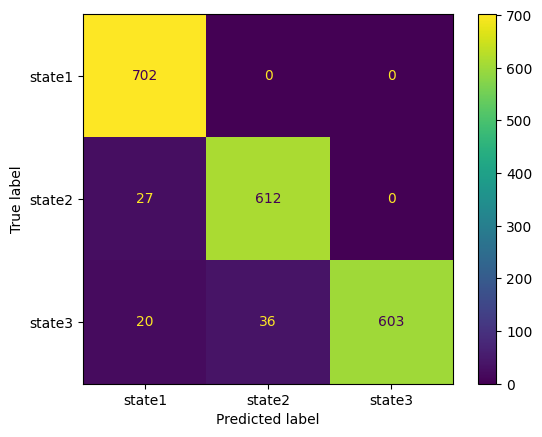

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


confusion_matrix = metrics.confusion_matrix(act_y, pred_y)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels=["state1","state2","state3"])
plt.figure(figsize=(10,10))
cm_display.plot()
plt.show()

In [ ]:
"""
LSM710(sullied):
  CentreResnet50: Train->95-97 Test-> 96
  CentreVGG16: Train->95-97 Test->95
LSD1:
  CentreResnet:CentreResnet,98.6,96.5
  CentreVGG16:CentreVGG16,98.5,93.8

"""